In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import statsmodels.formula.api as smf 
import pandas as pd
%matplotlib inline

### <center> Day36 - Last word on unbiasedness and causality

Today we'll simulate a world where your <b>GPA</b> is determined by  

+ Your weekly <b>attendance</b> (in hours)

+ Whether you are a <b>good</b> student or not (binary)

A crucial observation is that we'll force attendance and "goodness" to be <i>positively covariant.</i>

---

The function `generate_data` below produces variables coming from the specifically linear model:

$$GPA = b_0 + b_1 ATTEND + b_2 GOOD + \epsilon$$

In [3]:
def generate_data(n, corr = .5):
    
    # Unless you've taken linear algebra, don't worry about this block.
    A = np.array([[2,0],
                  [0,1]])
    W = np.array([[1, corr],
                  [corr ,1]])
    Sigma = A.dot(W)
    
    # Generates regressors. Argument cov is the "covariance matrix".
    X = ss.multivariate_normal(mean = [20, 0], 
                               cov = Sigma).rvs(n)
    # First column is attend
    attendance = X[:,0]
    # Second column is good (forced to be zero or one)
    good = (X[:,1] > 0).astype(int)
    
    # Error term, independent from regressors
    eps = ss.norm(0, .2).rvs(n)
    
    # Forming Y
    Y =  1 + .1 * attendance +  .5 * good + eps
    gpa = np.clip(Y, 0, 4) # Clip GPA to be in reasonable range
    
    # Forms the data set
    data = pd.DataFrame({'good': good, 'gpa':gpa, 'attendance':attendance})
    return data

In [35]:
df = generate_data(200, corr = .5)
df.head()

,attendance,good,gpa
0,20.851415,1,4.000000
1,20.698309,1,3.492562
2,20.132903,0,2.518536
3,21.165513,1,3.328924
4,19.985471,1,3.520772


---

### Wrong model

Suppose that you don't have any data on who are the good students. 

A scatterplot of your observed variables looks like this:

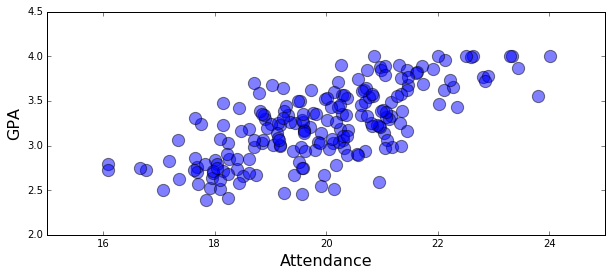

In [36]:
fig, ax = plt.subplots(1, figsize = (10, 4));
ax.scatter(df["attendance"], df["gpa"],  s = 150, alpha = .5);
ax.set_ylabel("GPA", fontsize = 16);
ax.set_xlabel("Attendance", fontsize = 16);

<b>Discuss</b>

+ Does the relationship look linear to you?

+ Suppose we linearly regress GPA on attendance:

$$GPA = c_0 + c_1 ATTENDANCE + u$$

What is your guess for the values of $\hat{c}_0$, $\hat{c}_1$?

+ If I told you how many hours a student spends at school, can you <b>predict</b> what's their GPA?

+ Can you infer the **causal effect** of attendance on GPA?

---

Let's actually run the regression.

If your data is stored in a `pandas DataFrame`, then running a linear regression is very easy using the `statsmodels.formula.api` module. You can find more about the syntax <a href="http://statsmodels.sourceforge.net/devel/example_formulas.html">here</a>. For now, just understand that we're regressing $gpa$ on $attend$.

In [37]:
ols = smf.ols("gpa ~ attendance", data = df).fit() # Fit a regression and store the results in "ols"
ols.summary()  # Print out the usual summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gpa   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     188.0
Date:                Fri, 02 Dec 2016   Prob (F-statistic):           1.61e-30
Time:                        15:27:50   Log-Likelihood:                -38.121
No. Observations:                 200   AIC:                             80.24
Df Residuals:                     198   BIC:                             86.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.5231      0.275     -1.903      0.058        -1.065     0.019
attendance     0.1887      0.014     13.711      0.000         0.162     0.216
==============================================================================
Omnibus:                        1.836   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.399   Jarque-Bera (JB):                1.917
Skew:                          -0.211   Prob(JB):                        0.383
Kurtosis:                       2.771   Cond. No.                         264.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

To predict the average GPA at a specific point, we pass it as a dictionary:

In [38]:
ols.predict({'attendance': 20}) 

array([ 3.25182666])

Let's predict GPA over grid of linearly spaced points of attendance

In [39]:
attendgrid = np.linspace(14, 24, 101) # [14, 14.1, 14.2 ..., 23.9, 24]
gpahat = ols.predict({'attendance':attendgrid}) # Average GPA given each point in grid

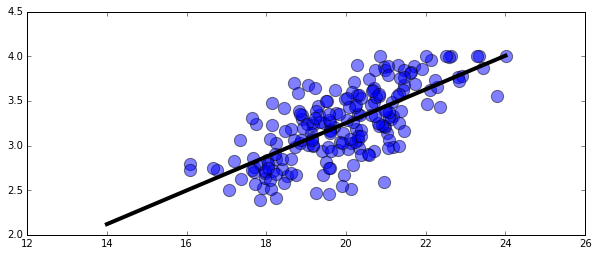

In [40]:
fig, ax = plt.subplots(1, figsize = (10, 4))
ax.scatter(df["attendance"], df["gpa"],  s = 150, alpha = .5)
ax.plot(attendgrid, gpahat, color = "black", linewidth = 4)

---

### Correct model

Now let's include the variable that was missing.

In [41]:
ols = smf.ols("gpa ~ attendance + good", data = df).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gpa   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     311.2
Date:                Fri, 02 Dec 2016   Prob (F-statistic):           1.07e-61
Time:                        15:27:51   Log-Likelihood:                 37.655
No. Observations:                 200   AIC:                            -69.31
Df Residuals:                     197   BIC:                            -59.42
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.8199      0.209      3.924      0.000         0.408     1.232
attendance     0.1092      0.011     10.073      0.000         0.088     0.131
good           0.4899      0.033     14.943      0.000         0.425     0.555
==============================================================================
Omnibus:                        2.603   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.272   Jarque-Bera (JB):                2.646
Skew:                          -0.246   Prob(JB):                        0.266
Kurtosis:                       2.726   Cond. No.                         294.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<b>Discussion</b>

+ What do you notice about the coefficients?

+ What extra information does the "good" variable give us?

+ If I told you how many hours a student spends at school, and if a student is good or not, can you <b>predict</b> what's their GPA?

+ Can you infer the **causal effect** of attendance on GPA?

----

Like before, let's predict over many different attendance levels, but this time let's also *control for* student "goodness".

In [42]:
gpahat_0 = ols.predict({'attendance':attendgrid, 'good':[0]*101}) # Predicts GPA for bad students
gpahat_1 = ols.predict({'attendance':attendgrid, 'good':[1]*101}) # Predicts GPA for good students

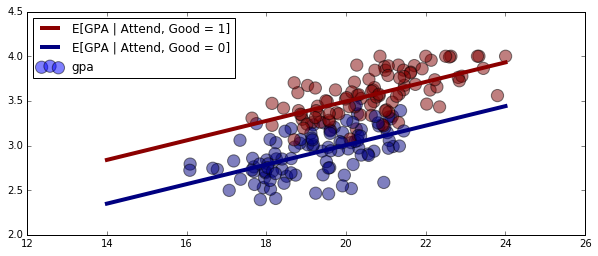

In [43]:
fig, ax = plt.subplots(1, figsize = (10, 4))
ax.scatter(df["attendance"], df["gpa"], c = df["good"], s = 150, alpha = .5)
ax.plot(attendgrid, gpahat_1, linewidth = 4, color = "darkred", label = "E[GPA | Attend, Good = 1]")
ax.plot(attendgrid, gpahat_0, linewidth = 4, color = "navy", label =  "E[GPA | Attend, Good = 0]")
ax.legend(loc = 2)

<b>Discussion</b>

+ Why are the lines parallel?

+ In real life, there's no variable "good". What can we use instead?

+ Give a different real-life example of a triple of variables that has the same structure as the "(gpa, attendance, good)" example here.

+ Next, we'll all the way to the beginning of this notebook and shut down the correlation betweeen attendance and good. 

    + How will the colored scatterplot change?
    
    + How do the coefficients $\hat{c}_1$ and $\hat{b}_1$ compare?
    
    + What do we conclude has to happen for us to be able to infer causal effects?

---

### Something confusing that happens in Econometrics

I'd like to show you how people are usually taught these ideas in econometrics.

The blue boxes below are screenshots from a famous econometrics textbook. 

+ Assumption 1 is about the functional form we assume for $E[Y|X=x]$

+ Assumption 2 says our sample is good

+ Assumption 3 is a technicality. Don't worry about it.

+ Assumption 4 implies that **the covariance between regressors and error term is zero.**

<font size = 1>Jeffrey M. Wooldridge. (2009). Introductory Econometrics: A modern approach. Canada: South-Western Cengage Learning.</font>

<img src="mlr1.png" width = 600>

<img src="mlr2.png" width = 600>

<img src="mlr3.png" width = 600>

<img src="mlr4.png" width = 600>

These assumptions form the basis for an important theorem.

<img src="thm3.png" width = 600>

I was very confused when I learned this as an undergrad. It *sounded* like Wooldridge was trying to say:

> If the four assumptions aren't satisfied, then you can't use linear regression.

Actually, under assumptions 1-3 only you still *can* use linear regression! Moreover, you can use your model for <b>prediction</b>. However, the model won't tell you anything about causal effects. If I were to write a textbook, I would say something like:

> Only assumptions 1-3 are satisfied, you'll have biased estimates of the <b>causal effects</b> of the regressors on the dependent variable. 